# Disclaimer

During the process of isolating single cells for analysis, it's possible to accidentally capture two cells instead of one. When this happens, we call it a "doublet." Doublets can complicate the analysis because they don't represent a single cell's behavior; instead, they are a mix of two different cells.

If doublets aren't removed, they can create misleading results. For example, if you're looking for unique cell types, a doublet might show characteristics of two different cell types, causing confusion. It can also affect downstream analyses, like clustering or identifying gene expression patterns.

That's why "doublet removal" is an essential step in single-cell analysis pipelines. It involves identifying and removing these doublets to ensure that the analysis focuses on true single-cell data. There are various methods to detect doublets, such as:

- **Statistical Analysis:** These methods look for outliers or unusual patterns in the data that suggest a doublet.
- **Machine Learning Models:** Some algorithms are trained to recognize patterns indicative of doublets.
- **Experimental Techniques:** In some cases, experimental methods can be used to separate single cells more accurately.

Here we use a **machine learning model** called **scVI**.

### scVI

scVI (Single-cell Variational Inference) is a tool designed for analyzing single-cell RNA sequencing (scRNA-seq) data. scVI use a function of deep learning known as "variational inference," to model complex data in an efficient and scalable way.

Here we use the **SOLO function** of scVI 

SOLO is a method developed to identify and remove doublets in single-cell data. It is built on top of the broader scVI framework, leveraging the same underlying principles of deep learning and probabilistic modeling. The key idea behind SOLO is to use a model-based approach to detect doublets with high accuracy and efficiency.

SOLO operates by training a variational autoencoder, a type of neural network, to learn patterns in single-cell data. The model is trained on data known to consist solely of single cells, allowing it to learn typical single-cell patterns. Once trained, the model can then be used to detect anomalies or patterns indicative of doublets in new datasets.


In [1]:
#For downloads
import gdown, os, gzip, shutil

# Basic data management and plotting
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import os
 
# Scanpy fundamentals
import anndata as ad
import scanpy as sc
import seaborn as sb

# sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(figsize=(6, 6))
import scvi

/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [8]:
%cd '/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad/'

/datos/home/jupyter-mdiaz/scRNAseq_pipeline/initial_h5ad


In [9]:
adata = sc.read_h5ad('control1')
adata

AnnData object with n_obs × n_vars = 5059 × 18023
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

# Doublet removal

We load 1 sample. It took ~10 minutos to run with the SOLO model.

**Note**: Time will depend on whether you have a GPU working while your data is being analyzed. If you are using a GPU, the time will be shorter.

In [10]:
adata

AnnData object with n_obs × n_vars = 5059 × 18023
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [11]:
sc.pp.filter_genes(adata, min_cells = 10)

In [12]:
#sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')

In [13]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/jupyter-mdiaz/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:758: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display drive

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/opt/tljh/user/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 400/400: 100%|██████████| 400/400 [10:43<00:00,  1.57s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=2.06e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [10:43<00:00,  1.61s/it, v_num=1, train_loss_step=2.34e+3, train_loss_epoch=2.06e+3]


In [14]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 218/400:  55%|█████▍    | 218/400 [01:27<01:13,  2.49it/s, v_num=1, train_loss_step=0.201, train_loss_epoch=0.259]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.251. Signaling Trainer to stop.


In [15]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

#df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
CCGGGATAGCTAGTGG,-0.297677,0.629262,singlet
GCAATCACAATGACCT,1.253553,-0.857474,doublet
CGGACGTAGGGTGTGT,-0.751078,0.483669,singlet
GTACGTACATGTCTCC,1.038179,-1.040410,doublet
TAGAGCTTCTGTGCAA,-1.030195,0.917973,singlet
...,...,...,...
ACTATCTCAATAGCGG,-2.208022,2.257040,singlet
CTGCTGTTCCTAGAAC,-1.324198,2.249975,singlet
GCGCAACCACAACGTT,-2.750820,3.857270,singlet
CGGGTCACATCGGAAG,-3.680461,3.609432,singlet


In [16]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1103,1103
singlet,3956,3956


In [17]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
CCGGGATAGCTAGTGG,-0.297677,0.629262,singlet,-0.926939
GCAATCACAATGACCT,1.253553,-0.857474,doublet,2.111027
CGGACGTAGGGTGTGT,-0.751078,0.483669,singlet,-1.234747
GTACGTACATGTCTCC,1.038179,-1.040410,doublet,2.078589
TAGAGCTTCTGTGCAA,-1.030195,0.917973,singlet,-1.948168
...,...,...,...,...
ACTATCTCAATAGCGG,-2.208022,2.257040,singlet,-4.465061
CTGCTGTTCCTAGAAC,-1.324198,2.249975,singlet,-3.574172
GCGCAACCACAACGTT,-2.750820,3.857270,singlet,-6.608090
CGGGTCACATCGGAAG,-3.680461,3.609432,singlet,-7.289893


In [18]:
import seaborn as sns

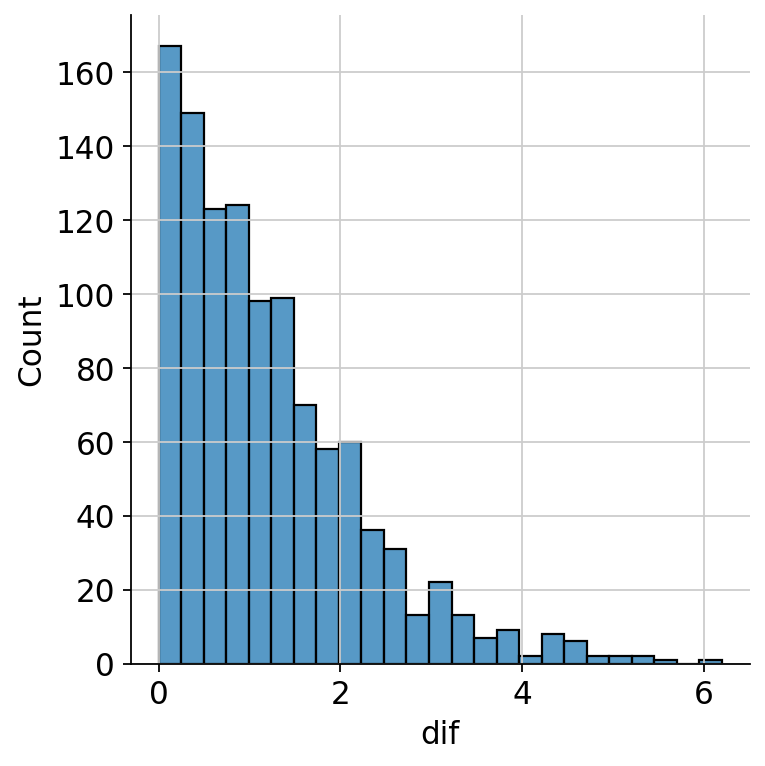

In [19]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [20]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

,doublet,singlet,prediction,dif
GCAATCACAATGACCT,1.253553,-0.857474,doublet,2.111027
GTACGTACATGTCTCC,1.038179,-1.040410,doublet,2.078589
CAGCAGCGTGGCTCCA,0.927543,-0.262378,doublet,1.189922
CCAATCCGTATCGCAT,0.642013,-0.927020,doublet,1.569033
CGCCAAGCAAAGGCGT,0.833887,-0.777049,doublet,1.610936
...,...,...,...,...
ACGGAGATCATTGCCC,0.839362,-1.191746,doublet,2.031108
GCTCCTACATTAGCCA,1.217786,-0.894151,doublet,2.111938
CCGTACTAGCAGGTCA,0.655943,-0.617749,doublet,1.273692
GTAGTCAAGTGAAGTT,0.753655,-0.466412,doublet,1.220067


In [21]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [22]:
adata.obs

,n_genes,_scvi_batch,_scvi_labels,doublet
CellID,,,,
CCGGGATAGCTAGTGG,821,0,0,False
GCAATCACAATGACCT,763,0,0,True
CGGACGTAGGGTGTGT,478,0,0,False
GTACGTACATGTCTCC,1373,0,0,True
TAGAGCTTCTGTGCAA,322,0,0,False
...,...,...,...,...
ACTATCTCAATAGCGG,396,0,0,False
CTGCTGTTCCTAGAAC,254,0,0,False
GCGCAACCACAACGTT,230,0,0,False


In [23]:
columns_to_drop = ['_scvi_batch', '_scvi_labels']

# Eliminar las columnas
adata.obs.drop(columns_to_drop, axis=1, inplace=True)

In [24]:
adata = adata[~adata.obs.doublet]

In [25]:
adata.obs

,n_genes,doublet
CellID,,
CCGGGATAGCTAGTGG,821,False
CGGACGTAGGGTGTGT,478,False
TAGAGCTTCTGTGCAA,322,False
ACTGATGAGACAAGCC,1584,False
TGGGCGTTCCATGAAC,243,False
...,...,...
ACTATCTCAATAGCGG,396,False
CTGCTGTTCCTAGAAC,254,False
GCGCAACCACAACGTT,230,False
